In [1]:
import os

import torch
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import functional as F
from pycocotools.coco import COCO
import torchvision.transforms.v2 as T
import torch.nn as nn
from torchvision.models import resnet18
from torchvision import transforms

import matplotlib.pyplot as plt
from itertools import cycle

from tqdm.notebook import tqdm

import random
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
COCO_PATH = "./data/coco/"  # change this
IMG_DIR_TRAIN = os.path.join(COCO_PATH, "images/train2017")
IMG_DIR_VAL = os.path.join(COCO_PATH, "images/val2017")
ANN_FILE_TRAIN = os.path.join(COCO_PATH, "annotations/person_keypoints_train2017.json")
ANN_FILE_VAL = os.path.join(COCO_PATH, "annotations/person_keypoints_val2017.json")

REMOVE_IMAGES_WITHOUT_KEYPOINTS = True
VAL_SPLIT = 0.5
TEST_VAL_TRAIN_PERCENT = (0.1, 0.1, 0.1)
BATCH_SIZE = 8
EPOCHS = 10

NUM_KEYPOINTS = 17
MAX_PERSONS = 5

# Data

In [4]:
class CustomTransform:
    def __init__(self, size=(256, 256)):
        self.transform = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor()
        ])
    
    def __call__(self, image, target):
        return self.transform(image), target
    

In [5]:
class CocoKeypointsDataset(CocoDetection):
    def __init__(self, img_folder, ann_file, transforms=None, filter_without_keypoints=True):
        super().__init__(img_folder, ann_file)
        self.coco = COCO(ann_file)
        self._transforms = transforms
        self.filter_without_keypoints = filter_without_keypoints

        if self.filter_without_keypoints:
            # Save the original ids before filtering
            original_ids = list(self.ids)  # Use self.ids after super().__init__
            self.ids = []
            for img_id in original_ids:
                ann_ids = self.coco.getAnnIds(imgIds=img_id, iscrowd=None)
                anns = self.coco.loadAnns(ann_ids)
                anns_with_kp = [ann for ann in anns if 'keypoints' in ann and np.any(np.array(ann['keypoints']) != 0)]
                if len(anns_with_kp) > 0:
                    self.ids.append(img_id)

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        orig_w, orig_h = img.size  # PIL image size (width, height)
        ann_ids = self.coco.getAnnIds(imgIds=self.ids[idx], iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)

        if self.filter_without_keypoints:
            # Filter for annotations with keypoints
            anns = [ann for ann in anns if 'keypoints' in ann and np.any(np.array(ann['keypoints']) != 0)]
        else:
            anns = [ann for ann in anns if 'keypoints' in ann]

        target = {
            "image_id": self.ids[idx],
            "annotations": anns,
            "orig_size": (orig_w, orig_h)
        }
        if self._transforms:
            img, target = self._transforms(img, target)
        return img, target


In [6]:
def coco_collate_fn(batch):
    imgs, targets = zip(*batch)
    imgs = torch.stack([img for img in imgs])
    batch_size = len(imgs)
    keypoints_tensor = torch.zeros((batch_size, MAX_PERSONS, NUM_KEYPOINTS, 3), dtype=torch.float32)
    for i, t in enumerate(targets):
        anns = t['annotations']
        orig_w, orig_h = t['orig_size']
        for j, ann in enumerate(anns[:MAX_PERSONS]):
            kp = torch.tensor(ann['keypoints']).view(NUM_KEYPOINTS, 3).float()
            kp[:, 0] = kp[:, 0] * (256.0 / orig_w)
            kp[:, 1] = kp[:, 1] * (256.0 / orig_h)
            keypoints_tensor[i, j] = kp
    return imgs, keypoints_tensor

In [ ]:
train_dataset = CocoKeypointsDataset(IMG_DIR_TRAIN, ANN_FILE_TRAIN, transforms=CustomTransform(), filter_without_keypoints=REMOVE_IMAGES_WITHOUT_KEYPOINTS)
val_dataset = CocoKeypointsDataset(IMG_DIR_VAL, ANN_FILE_VAL, transforms=CustomTransform(), filter_without_keypoints=REMOVE_IMAGES_WITHOUT_KEYPOINTS)

val_size = int(VAL_SPLIT * len(val_dataset))
test_size = len(val_dataset) - val_size
val_dataset, test_dataset = random_split(val_dataset, [val_size, test_size])


In [ ]:
print("train dataset size:", len(train_dataset))
print("val dataset size:", len(val_dataset))
print("test dataset size:", len(test_dataset))

train dataset size: 56599
val dataset size: 1173
test dataset size: 1173


In [ ]:
subset_len_train = int(TEST_VAL_TRAIN_PERCENT[0] * len(train_dataset))
subset_len_val = int(TEST_VAL_TRAIN_PERCENT[1] * len(val_dataset))
subset_len_test = int(TEST_VAL_TRAIN_PERCENT[2] * len(test_dataset))

train_dataset = torch.utils.data.Subset(train_dataset, range(subset_len_train))
val_dataset = torch.utils.data.Subset(val_dataset, range(subset_len_val))
test_dataset = torch.utils.data.Subset(test_dataset, range(subset_len_test))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=coco_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=coco_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=coco_collate_fn)

In [ ]:
print("train dataset size:", len(train_dataset))
print("val dataset size:", len(val_dataset))
print("test dataset size:", len(test_dataset))

train dataset size: 565
val dataset size: 117
test dataset size: 117


## Visualize data

In [ ]:
def visualize_prediction(img_tensor, keypoints_tensor):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    plt.imshow(img)
    colors = cycle(plt.cm.tab10.colors)
    # Plot GT keypoints for all persons
    for i, kp in enumerate(keypoints_tensor):
        kp = kp.cpu().numpy()
        if np.all(kp == 0):
            continue
        color = next(colors)
        plt.scatter(kp[:, 0], kp[:, 1], color=color, label=f'GT {i+1}')
    plt.show()

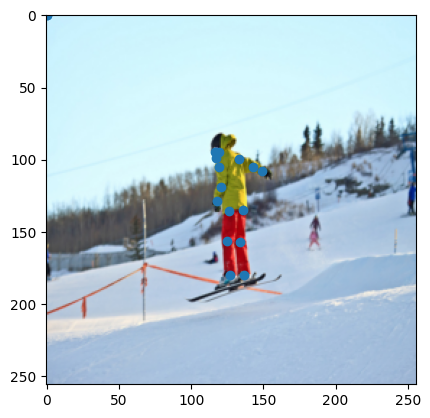

Person 1 keypoints:
tensor([[117.2000,  98.9227,   2.0000],
        [116.8000,  94.7260,   2.0000],
        [  0.0000,   0.0000,   0.0000],
        [119.6000,  94.7260,   2.0000],
        [  0.0000,   0.0000,   0.0000],
        [119.2000, 104.9180,   2.0000],
        [133.2000,  99.5222,   2.0000],
        [120.4000, 118.7073,   2.0000],
        [142.8000, 104.9180,   2.0000],
        [117.6000, 128.2998,   2.0000],
        [149.2000, 107.9157,   2.0000],
        [126.0000, 135.4941,   2.0000],
        [135.6000, 134.8946,   2.0000],
        [124.8000, 156.4778,   2.0000],
        [134.0000, 157.0773,   2.0000],
        [126.8000, 179.8595,   2.0000],
        [136.8000, 179.8595,   2.0000]])
Person 2 keypoints:
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0.

In [ ]:
imgs, targets = next(iter(test_loader))

if 'test_iter' not in globals():
    test_iter = iter(test_loader)
try:
    imgs, targets = next(test_iter)
except StopIteration:
    test_iter = iter(test_loader)
    imgs, targets = next(test_iter)

imgs = imgs.to(device)


idx = random.randint(0, imgs.shape[0] - 1)
img = imgs[idx].cpu()
keypoints = targets[idx]  # (MAX_PERSONS, 17, 3)

visualize_prediction(img, keypoints)


for i, kp in enumerate(keypoints):
    print(f"Person {i+1} keypoints:\n{kp}")

# Model

In [ ]:
class KeypointModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = resnet18(pretrained=True)
        # Output: (batch, MAX_PERSONS * NUM_KEYPOINTS * 3)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, MAX_PERSONS * NUM_KEYPOINTS * 3)

    def forward(self, x):
        x = self.backbone(x)
        
        # Reshape to (batch, MAX_PERSONS, NUM_KEYPOINTS, 3)
        x = x.view(x.size(0), MAX_PERSONS, NUM_KEYPOINTS, 3)

        # Apply sigmoid to visibility logit (last channel)
        coords = x[..., :2]  # (x, y)
        visibility_logit = x[..., 2]  # (logit)
        visibility = torch.sigmoid(visibility_logit)

        # Concatenate coords and visibility along last dim
        out = torch.cat([coords, visibility.unsqueeze(-1)], dim=-1)

        return out

In [ ]:
# class KeypointModel(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(64, 192, kernel_size=5, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(192, 384, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(384, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#         )
#         self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
#         self.classifier = nn.Sequential(
#             nn.Dropout(),
#             nn.Linear(256 * 6 * 6, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             # Output: (MAX_PERSONS, NUM_KEYPOINTS, 3) where 3 = (x, y, visibility)
#             nn.Linear(4096, MAX_PERSONS * NUM_KEYPOINTS * 3),
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         x = self.classifier(x)
#         x = x.view(x.size(0), MAX_PERSONS, NUM_KEYPOINTS, 3)
#         return x

In [ ]:
def train_one_epoch(model, dataloader, optimizer, criterion, use_tqdm=False):
    model.train()
    total_loss = 0

    enumerator = tqdm(dataloader) if use_tqdm else dataloader
    for imgs, keypoints in enumerator:
        imgs = imgs.to(device)
        keypoints = keypoints.to(device)
        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds, keypoints)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

In [ ]:
def evaluate(model, dataloader):
    model.eval()
    preds_list, gt_list = [], []
    with torch.no_grad():
        for imgs, keypoints in dataloader:
            imgs = imgs.to(device)
            keypoints = keypoints.to(device)
            preds = model(imgs)
            preds_list.append(preds.cpu())
            gt_list.append(keypoints.cpu())
    # Concatenate all batches
    preds_all = torch.cat(preds_list, dim=0)
    gt_all = torch.cat(gt_list, dim=0)
    return preds_all, gt_all

# Train

In [ ]:
# EPOCHS = 10


In [ ]:
model = KeypointModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

c:\Users\patry\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\patry\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
train_losses = []
val_losses = []

for epoch in tqdm(range(EPOCHS)):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    train_losses.append(train_loss)

    preds_all, gt_all = evaluate(model, val_loader)
    val_loss = criterion(preds_all, gt_all).item()
    val_losses.append(val_loss)

    # print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

  0%|          | 0/10 [00:00<?, ?it/s]

# Visualize

In [ ]:
def visualize_prediction(img_tensor, keypoints_tensor, pred_keypoints_tensor=None):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    plt.imshow(img)
    colors = cycle(plt.cm.tab10.colors)
    # Plot GT keypoints for all persons
    for i, kp in enumerate(keypoints_tensor):
        kp = kp.cpu().numpy()
        if np.all(kp == 0):
            continue
        color = next(colors)
        plt.scatter(kp[:, 0], kp[:, 1], color=color, label=f'GT {i+1}')
    # Plot predicted keypoints for all persons
    if pred_keypoints_tensor is not None:
        colors_pred = cycle(plt.cm.Dark2.colors)
        for i, pk in enumerate(pred_keypoints_tensor):
            pk = pk.cpu().numpy()
            pk = pk[pk[:, 2] >= 0.5]

            color = next(colors_pred)
            plt.scatter(pk[:, 0], pk[:, 1], color=color, marker='x', label=f'Pred {i+1}')
    # plt.legend()
    plt.show()

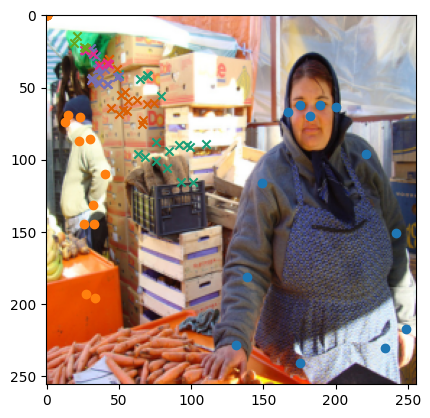

Person 1 keypoints:
tensor([[ 79.3122,  55.5990,   1.0000],
        [ 69.8256,  42.1771,   1.0000],
        [ 64.4401,  44.2470,   1.0000],
        [ 69.4080,  41.5494,   0.9999],
        [ 49.6947,  40.2949,   0.9998],
        [109.9253,  89.1208,   1.0000],
        [ 97.1406,  89.4600,   1.0000],
        [ 98.8693,  90.9052,   1.0000],
        [ 84.6631,  93.6689,   1.0000],
        [ 91.7737,  89.6081,   1.0000],
        [ 75.5968,  87.9625,   1.0000],
        [101.3871, 115.6180,   1.0000],
        [ 93.1571, 115.1286,   1.0000],
        [ 83.1660, 105.7778,   0.9999],
        [ 75.5011, 100.9814,   1.0000],
        [ 67.9111,  98.2399,   0.9984],
        [ 63.4374,  95.6848,   0.9999]])
Person 2 keypoints:
tensor([[48.7827, 37.3227,  0.9118],
        [42.9711, 30.4654,  0.7697],
        [41.8912, 32.4576,  0.9590],
        [43.3019, 30.3366,  0.6559],
        [38.2355, 34.0832,  0.9628],
        [74.0239, 60.6087,  0.9997],
        [69.5158, 61.0475,  0.9994],
        [62.1825, 58

In [ ]:
imgs, targets = next(iter(test_loader))
imgs = imgs.to(device)
with torch.no_grad():
    preds = model(imgs)

idx = random.randint(0, imgs.shape[0] - 1)
img = imgs[idx].cpu()
gt_kpts_list = targets[idx]  # (MAX_PERSONS, 17, 3)
pred_kpts_list = preds[idx].cpu()  # (MAX_PERSONS, 17, 3)

visualize_prediction(img, gt_kpts_list, pred_kpts_list)

for i, kp in enumerate(pred_kpts_list):
    print(f"Person {i+1} keypoints:\n{kp}")

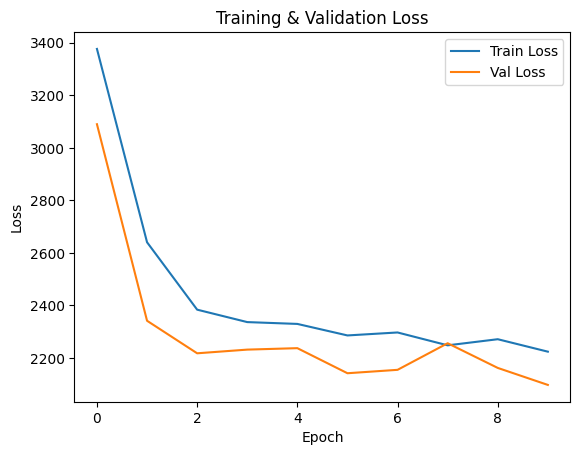

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training & Validation Loss")
plt.show()